# Overview

## General Goal
- Want to focus on modeling in sample skewing, done with a continuous encoder model
- Can model in discrete dropout errors later as well (already in math model, in progress as discretelossyencoder below) 
- Need to keep functions generalizable

## Modularization
Break into many transformations:

- Module 1: Patient samples viral load -> RT-LAMP molecules -> PCR molecules -> Gets pooled into sequencing
- Module 2: Sequencing reads -> thresholded to produce binary output
- Module 3: Binary output (0 or 1 for each barcode) -> Naive decoder for k' out of k. 

Initial focus is on last two modules, modeling the first module requires experimental data.

## Module 2 Model

Currently, molecules to be sequenced are modeled as:
- having amplified initial viral titer loads, log normal distribution with mean = 4.5, std = 3
- having saturating amplification functions, normalizing initial viral titer loads, normal distribution with mean 10000, std 1000

To go from sequencing read to binary output:
- Fractional abundance for each barcode calculated by dividing by total number of molecules for a subbatch is computed
- If fractional abundance for a barcode*total good reads per subbatch > threshold, 1. Otherwise 0 

## To Do

- Check discretelossyencoder function and implementation
- Characterize real transformations for module 1 (experimentally)
- Parallelize computation for more iterations/parameters

In [1]:
#Import useful general  libraries
import numpy as np
import random
from random import seed
from random import randint
from tqdm.notebook import tnrange,tqdm_notebook

#Packages for data analysis/stats
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score, confusion_matrix

#Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [81]:
#General Parameters 
prob = 0.01 #Percent of population infected
m = 10000 #Number of barcode 1s
k = 5 #Number of barcode 1s per patient sample
kprime = 3 #Number of barcode 1s required to call sample positive
b = 10000 #Number of patient samples per subbatch
n = int(np.ceil(b*prob)) #Number of positive samples per subbatch (with a rounding error)

#Parameters for discretelossyencoder
dsynth = 0.001 #Proportion of barcode 1s that always fail
dstoch = 0.005 #Proportion of stochastically failure

#Parameters for continuousencoder
totalreads = 200000000 #Reads per illumina run
readspersubbatch = totalreads/10 #Reads per subbatch
propnoise = 0.1 #Fraction of reads that are junk
goodreads = int(np.ceil((1-propnoise)*readspersubbatch)) #Number of good reads per subbatch (with a rounding error)
threshold = 200 #Reads required to call a sample positive, 100, 1000
setting = "Saturated" #"Saturated" #"Amp" #Either "Amp" or "Saturated" describing model

In [87]:
#Helper Functions

def discretelosslessencoder(truth, m, k):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
    
    Outputs:
        barcodetruth - array (1 x m), 0 if negative, 1 if positive
    '''
    #Initialize barcode matrix
    barcodetruth = np.zeros((1, m)).astype(int)
    
    #Iterate through samples in truth and set corresponding barcodes to 1
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #print("sample index: ", samp)
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                bcindex = randint(0, m-1) #Generate barcode index for scenario 2
                #bcindex = samp #Generate barcode index for scenario 1
                #print(bcindex)
                barcodetruth[0, bcindex]=1 #Set barcode to 1
                
    return barcodetruth

def discretelossyencoder(truth, m, k, dsynth, dstoch):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    Includes error where some barcodes always fail
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
    
    Outputs:
        lossybarcodetruth - array (1 x m), 0 if negative, 1 if positive
    '''
    #Generate lossybarcodetruth vector
    lossybarcodetruth = np.zeros((1, m)).astype(int)
    
    #Iterate through samples in truth and set corresponding barcodes to 1
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #print("sample index: ", samp)
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                bcindex = randint(0, m-1) #Generate barcode index for scenario 2
                #print(bcindex)
                #bcindex = samp #Generate barcode index for scenario 1
                randomprob = random.random()
                if randomprob >= dstoch: #Fails dstoch proportion of the time
                    lossybarcodetruth[0, bcindex]=1 #Set barcode to 1
    
    #Calculate the number of barcodes that always fail (with a rounding error)
    numzeros = int(np.ceil(m*dsynth))
    
    #Generate indices that should be 0
    index_list = [] 
    while len(index_list) < numzeros:
        random_int = randint(0, m-1)
        if random_int not in index_list:
            index_list.append(random_int)
    
    #Set those indices to 0
    for position in index_list:
        lossybarcodetruth[0, position] = 0
                
    return lossybarcodetruth

def continuousencoder(truth, m, k, goodreads, threshold, setting):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    Includes sampling error across samples
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
        goodreads - good reads allocated per subbatch
        threshold - reads needed to call something positive
        setting - distribution model, either "amp" or "saturated"
    
    Outputs:
        lossybarcodetruth - array (1 x m), 0 if negative, 1 if positive
    '''
    #Generate lossybarcodetruth vector
    lossybarcodetruth = np.zeros((1, m))
    
    #Iterate through samples in truth and set corresponding barcodes to 1
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #print("sample index: ", samp)
            seed(samp) #Set seed to RNG as sample index
            if setting == "Amp":
                moleculenumber=np.random.lognormal(4.5,3, size=None)
            if setting == "Saturated":
                moleculenumber=np.random.normal(10000,1000, size=None)
            for bc in range(k):
                bcindex = randint(0, m-1) #Generate barcode index for Scenario 2
                #bcindex = samp #Generate barcode index for Scenario 1
                #print(bcindex)
                lossybarcodetruth[0, bcindex]=moleculenumber
    #print(lossybarcodetruth)
    
    #Model for sequencer 
    lossybarcodetruthseqd = lossybarcodetruth/np.sum(lossybarcodetruth)*goodreads
    #print(lossybarcodetruthseqd)
    
    #Threshold and return to 0 or 1
    lossbarcodetruth = np.where(lossybarcodetruthseqd > threshold, 1, 0).astype(int)
                
    return lossbarcodetruth

def naivedecoder(apparentbarcode, b, k, kprime):
    '''
    Function takes np array of which barcodes are pos/neg and returns np array of which patient samples seem pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        apparentbarcode - array (1 x m), matrix of pos/neg barcodes
        b - number of patient samples per batch
        k - number of barcode 1s per patient sample
        kprime - required number of barcode 1s positive to call a sample positive
    
    Outputs:
        inferredtruth - array (1 x b), 0 if negative, 1 if positive, decoded patient samples
    '''
    #Initialize barcode matrix
    inferredtruth = np.zeros((1, b)).astype(int)
    
    #Iterate through samples in truth, setting to 1 if >= k' out of k barcodes positive
    (apparentbarcode1, apparentbarcode2) = apparentbarcode.shape
    for samp in range(b):
        seed(samp) #Set seed to RNG as sample index
        currentsamplesum = 0
        for bc in range(k):
            bcindex = randint(0, apparentbarcode2-1) #Generate barcode index for scenario 2
            # bcindex = samp #Generate barcode index for scenario 1
            if apparentbarcode[0, bcindex]==1:
                currentsamplesum += 1
        if int(currentsamplesum) >= kprime:
            inferredtruth[0, samp] = 1
    return inferredtruth


def inferenceanalysis(groundtruth, inferredtruth):
    '''
    Function takes np array of which patient samples truely are pos/neg and are inferred to be pos/neg
    Returns tn, fp, fn, tp probabilities as array
    
    Inputs:
        groundtruth - array (1 x b), 0 if negative, 1 if positive, true patient samples
        inferredtruth - array (1 x b), 0 if negative, 1 if positive, decoded patient samples
        
    Outputs:
        
    '''
    [tn, fp, fn, tp] = confusion_matrix(groundtruth[0], inferredtruth[0]).ravel()
    return [tn, fp, fn, tp] #[fp/(tn+fp), fn/(fn+tp)]

In [88]:
#Main Script

FPPs = []
FNPs = []
dropout = []

for iterations in tqdm_notebook(range(1000)):
    #Initialize arrays to represent ground truth
    initarray = np.array([0] * (b-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    
    #Encode groundtruth into barcode vector
    barcodetruth = discretelosslessencoder(groundtruth, m, k)
    barcodelossytruth = continuousencoder(groundtruth, m, k, goodreads, threshold, setting)
    #barcodelossytruth2 = discretelossyencoder(groundtruth, m, k, dsynth, dstoch)
    
    #Decode barcode vector to recover inferred truth
    inferredsamples = naivedecoder(barcodelossytruth, b, k, kprime)
    
    #Compare inferred versus ground truth
    '''
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredsamples)
    FPPs.append(FPP)
    FNPs.append(FNP)
    '''
    [tns, fps, fns, tps] = inferenceanalysis(groundtruth, inferredsamples)
    #print(tns, fps, fns, tps)
    FPP = fps/(tns+fps)
    FNP = fns/(fns+tps)
    
    #Store relevant parameters
    dropout.append(np.sum(barcodetruth-barcodelossytruth))
    FPPs.append(FPP)
    FNPs.append(FNP)

# Results for Scenario 1 (k'=k=1), Setting = "Saturated", Threshold = 100

-0.474


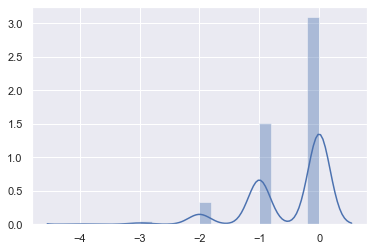

In [78]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

#This is because the current way discretelosslessencoder is written still has random hashing. 

0.0


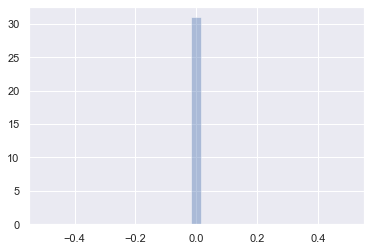

In [79]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0


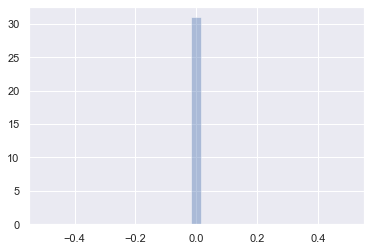

In [80]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 1 (k'=k=1), Setting = "Amp", Threshold = 2

0.388


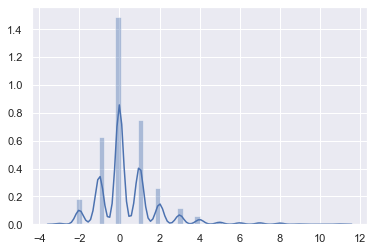

In [67]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

#This is because the current way discretelosslessencoder is written still has random hashing. 

0.00865


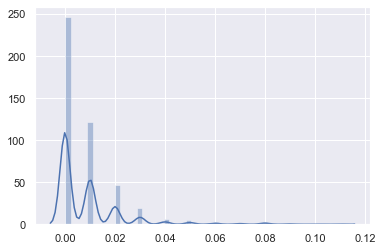

In [68]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0


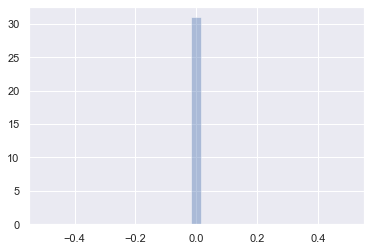

In [69]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 1 (k'=k=1), Scenario = "Amp", Threshold = 10

2.509


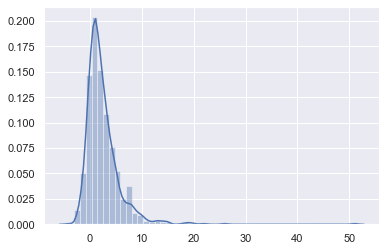

In [62]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

#This is because the current way discretelosslessencoder is written still has random hashing. 

0.029610000000000004


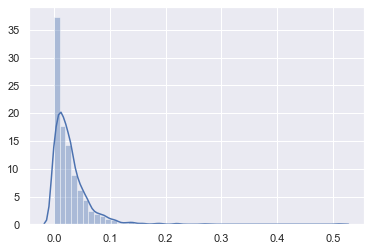

In [63]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

/Users/dli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/dli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


0.0


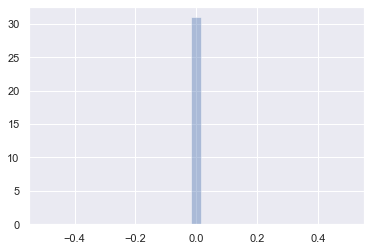

In [64]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 1 (k'=k=1), Setting = "Amp", Threshold = 100

11.815


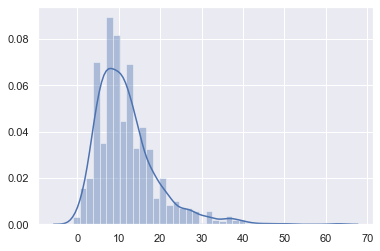

In [74]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

#This is because the current way discretelosslessencoder is written still has random hashing. 

0.12265000000000001


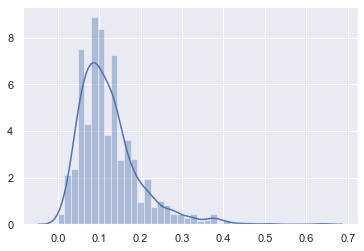

In [72]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0


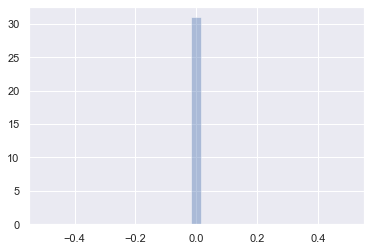

In [73]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Saturated", Threshold = 100

/Users/dli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/dli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


0.0


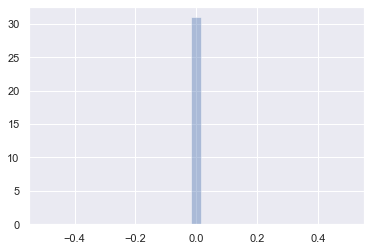

In [6]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.0


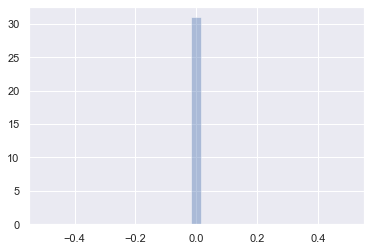

In [7]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0010669696969696969


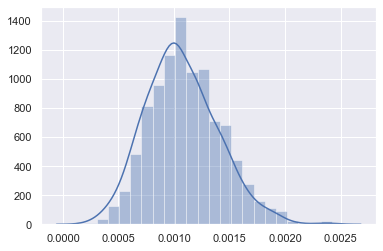

In [8]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Saturated", Threshold = 100

0.0


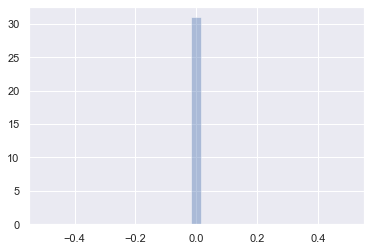

In [89]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.0


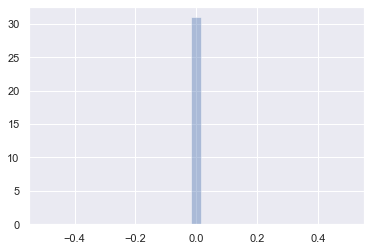

In [90]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0010664646464646466


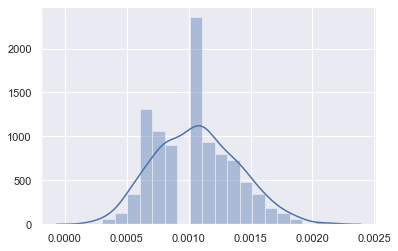

In [91]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Amp", Threshold = 2

14.102


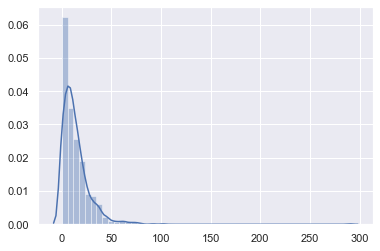

In [40]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.028910000000000005


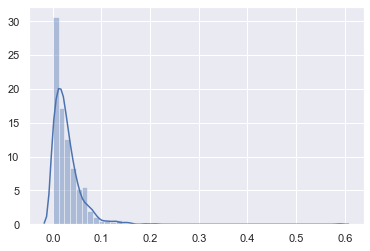

In [41]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0009804040404040404


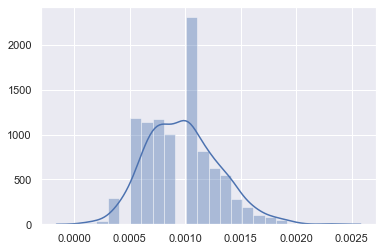

In [42]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Amp", Threshold = 10

39.917


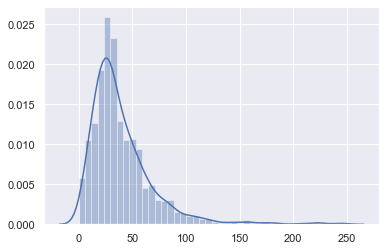

In [11]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.08172000000000001


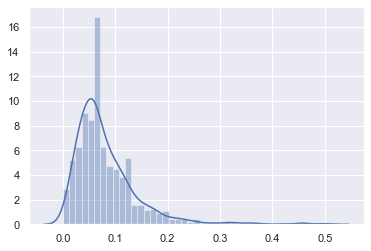

In [12]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0008657575757575757


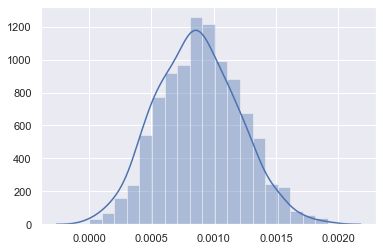

In [13]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Amp", Threshold = 50

92.597


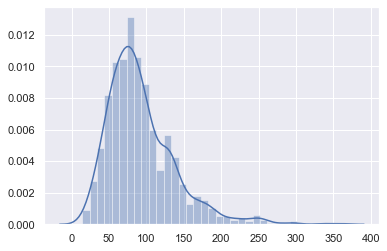

In [16]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.18969000000000003


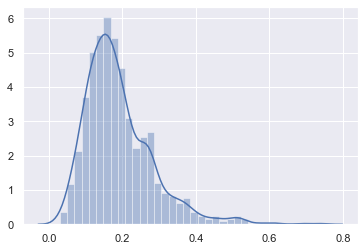

In [17]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.0006052525252525253


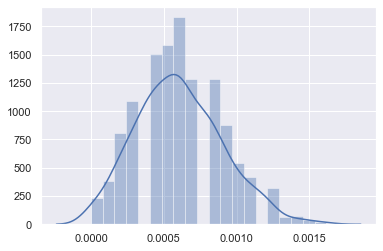

In [18]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5), Setting = "Amp", Threshold = 100

125.149


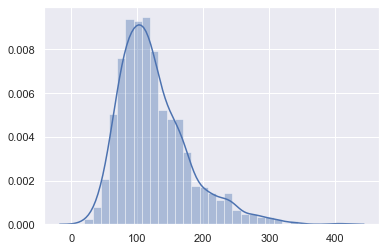

In [21]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.25667


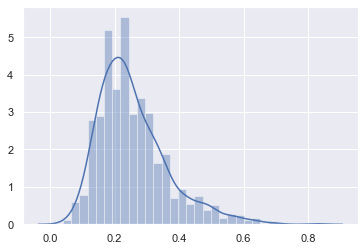

In [22]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.000492020202020202


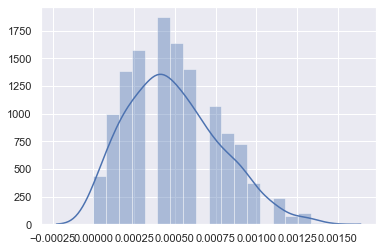

In [23]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5),  Setting = "Amp", Threshold = 500

213.955


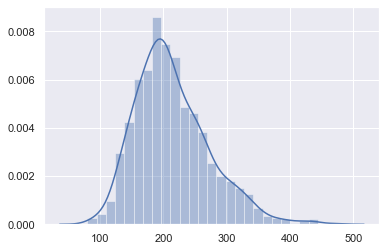

In [26]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.4387


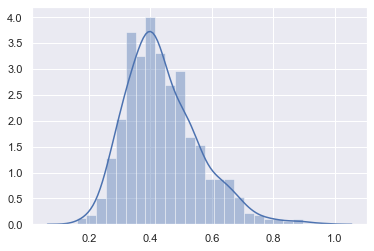

In [27]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.00022313131313131312


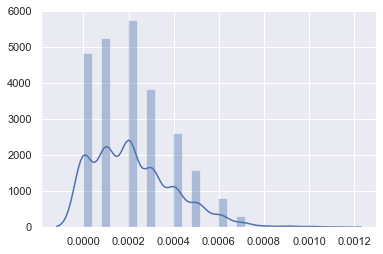

In [28]:
#Plot false positive probabilities
sns.distplot(FPPs)#, kde=False)
print(np.mean(FPPs))

# Results for Scenario 2 (k' = 3, k = 5),  Setting = "Amp", Threshold = 1000

256.327


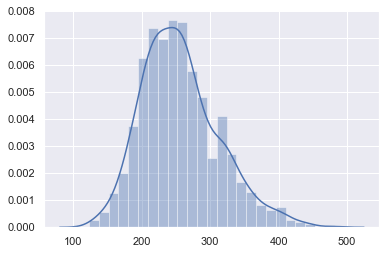

In [31]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)#, kde=False)
print(np.mean(dropout))

0.52549


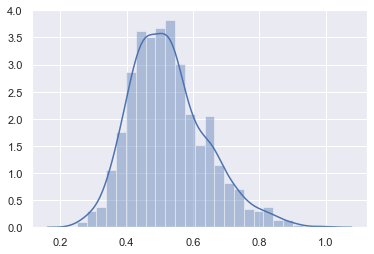

In [32]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print(np.mean(FNPs))

0.00013676767676767677


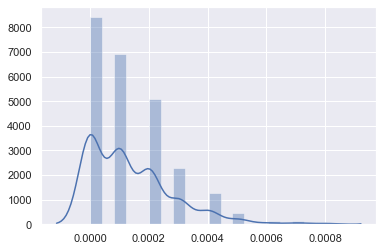

In [37]:
#Plot false negative probabilities
sns.distplot(FPPs) #, kde=False)
print(np.mean(FPPs))